# PM5 – Task H: Model Order Reduction POD

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import eigs, splu
from scipy.linalg import eig, solve, lu_factor, lu_solve
import time

# Import sonar simulation functions
from getParam_Sonar import getParam_Sonar
from eval_f_Sonar import eval_f_Sonar
from eval_g_Sonar import eval_g_Sonar
from eval_u_Sonar import eval_u_Sonar
from simpleLeapFrog import LeapfrogSolver

In [ ]:
# ============================================================
# FULL-ORDER MODEL SETUP
# ============================================================

# Grid size: 360×240 = 86,400 spatial points → 172,800 state variables
# Higher resolution to support 1-6 kHz frequency sweep + harmonics
Nx, Nz = 360, 240

# Domain size: 45m×30m (90λ × 60λ at 3kHz)
Lx, Lz = 45.0, 30.0

print(f"Setting up {Nx}×{Nz} grid over {Lx}m × {Lz}m domain")
print(f"State dimension: 2N = {2*Nx*Nz}")

# Get parameters
p, x_start, t_start, t_stop, max_dt_FE = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)

# Center the source (getParam_Sonar defaults to Nx//4)
p['sonar_ix'] = Nx // 2
N = Nx * Nz
source_idx = p['sonar_ix'] * Nz + p['sonar_iz']
B_lil = sp.lil_matrix((2*N, 1), dtype=float)
B_lil[N + source_idx, 0] = 1.0 / (p['dx'] * p['dz'])
p['B'] = B_lil.tocsr()

# Two hydrophones: one co-located with source, one downstream
hydro_1_x = Nx // 3  # First hydrophone (co-located with source at index 15 from Nx//4)
hydro_2_x = 2* Nx // 3  # Second hydrophone (at index 30 from Nx//4)
spacing = hydro_2_x - hydro_1_x  # Spacing between hydrophones

# Override source to match first hydrophone
p['sonar_ix'] = hydro_1_x
source_idx = p['sonar_ix'] * Nz + p['sonar_iz']
B_lil = sp.lil_matrix((2*N, 1), dtype=float)
B_lil[N + source_idx, 0] = 1.0 / (p['dx'] * p['dz'])
p['B'] = B_lil.tocsr()

p['hydrophones'] = {
    'z_pos': p['sonar_iz'],
    'x_indices': [hydro_1_x, hydro_2_x],
    'n_phones': 2
}

# Calculate separation distance
separation_m = (hydro_2_x - hydro_1_x) * p['dx']

print(f"✓ Source at x-index {p['sonar_ix']} = {p['sonar_ix']*p['dx']:.1f}m")
print(f"✓ Hydrophone 1 (co-located): x-index {hydro_1_x} = {hydro_1_x*p['dx']:.1f}m")
print(f"✓ Hydrophone 2: x-index {hydro_2_x} = {hydro_2_x*p['dx']:.1f}m")
print(f"✓ Separation: {separation_m:.2f}m → expected delay: {separation_m/1500*1e3:.1f} ms")
print(f"✓ Max stable dt: {max_dt_FE:.6f}s")

# Verify Nyquist criterion for target frequency range
print(f"\n=== NYQUIST VERIFICATION (1-6 kHz + harmonics) ===")
for f in [1000, 3000, 4000, 6000, 8000]:  # Test frequencies including 2× harmonic
    wavelength = 1500 / f
    ppw_x = wavelength / p['dx']
    ppw_z = wavelength / p['dz']
    status = "✓" if min(ppw_x, ppw_z) >= 2 else "⚠️" if min(ppw_x, ppw_z) >= 1 else "✗"
    print(f"{f:5d} Hz: λ={wavelength:.3f}m → {ppw_x:.1f}×{ppw_z:.1f} pts/λ {status}")

# Input: 3 kHz pulse with amplified amplitude

# Note: B matrix already has 1/(dx*dz) scaling, so u(t) just needs amplitude
amplitude_scale = 1e6  
print(f"Input amplitude: {amplitude_scale:.1e} × base pulse")
print(f"\nModel ready for POD analysis!")

def eval_u_scaled(t):
    return amplitude_scale * eval_u_Sonar(t)

Setting up 360×240 grid over 45.0m × 30.0m domain
State dimension: 2N = 172800
✓ Source at x-index 120 = 15.0m
✓ Hydrophone 1 (co-located): x-index 120 = 15.0m
✓ Hydrophone 2: x-index 240 = 30.1m
✓ Separation: 15.04m → expected delay: 10.0 ms
✓ Max stable dt: 0.000030s

=== NYQUIST VERIFICATION (1-6 kHz + harmonics) ===
 1000 Hz: λ=1.500m → 12.0×12.0 pts/λ ✓
 3000 Hz: λ=0.500m → 4.0×4.0 pts/λ ✓
 4000 Hz: λ=0.375m → 3.0×3.0 pts/λ ✓
 6000 Hz: λ=0.250m → 2.0×2.0 pts/λ ⚠️
 8000 Hz: λ=0.188m → 1.5×1.5 pts/λ ⚠️
Input amplitude: 1.0e+06 × base pulse

Model ready for POD analysis!
✓ Source at x-index 120 = 15.0m
✓ Hydrophone 1 (co-located): x-index 120 = 15.0m
✓ Hydrophone 2: x-index 240 = 30.1m
✓ Separation: 15.04m → expected delay: 10.0 ms
✓ Max stable dt: 0.000030s

=== NYQUIST VERIFICATION (1-6 kHz + harmonics) ===
 1000 Hz: λ=1.500m → 12.0×12.0 pts/λ ✓
 3000 Hz: λ=0.500m → 4.0×4.0 pts/λ ✓
 4000 Hz: λ=0.375m → 3.0×3.0 pts/λ ✓
 6000 Hz: λ=0.250m → 2.0×2.0 pts/λ ⚠️
 8000 Hz: λ=0.188m → 1.5×1

In [33]:
# ============================================================
# REFERENCE SIMULATION WITH LEAPFROG SOLVER
# ============================================================

# Simulation parameters
# Domain 45m×30m → ~30ms to cross → simulate for 40ms (includes reflections)
t_sim = 0.04  # seconds (40 ms)
dt = max_dt_FE * 0.5  # Half of max stable timestep for safety
num_steps = int(np.ceil(t_sim / dt))

print(f"Running reference simulation...")
print(f"  Duration: {t_sim*1000:.1f} ms")
print(f"  Timestep: {dt*1e6:.2f} μs")
print(f"  Number of steps: {num_steps}")
print(f"  State dimension: {x_start.shape[0]}")
print(f"\nThis may take 30 sec - 1 min for 173k states...")

t0 = time.perf_counter()
X_ref, t_ref = LeapfrogSolver(
    eval_f_Sonar, 
    x_start, 
    p, 
    eval_u_scaled, 
    num_steps, 
    dt, 
    visualize=False,
    verbose=True
)
sim_time = time.perf_counter() - t0

print(f"\n✓ Simulation complete in {sim_time:.2f}s")
print(f"✓ State history: {X_ref.shape} ({X_ref.nbytes/1e6:.1f} MB)")
print(f"✓ Time vector: {len(t_ref)} samples")

Running reference simulation...
  Duration: 40.0 ms
  Timestep: 14.77 μs
  Number of steps: 2708
  State dimension: 172800

This may take 1-2 minutes for 173k states...
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 2707 leapfrog steps...
  Progress: 10.0%
  Progress: 10.0%
  Progress: 19.9%
  Progress: 19.9%
  Progress: 29.9%
  Progress: 29.9%
  Progress: 39.9%
  Progress: 39.9%
  Progress: 49.9%
  Progress: 49.9%
  Progress: 59.8%
  Progress: 59.8%
  Progress: 69.8%
  Progress: 69.8%
  Progress: 79.8%
  Progress: 79.8%
  Progress: 89.7%
  Progress: 89.7%
  Progress: 99.7%
Leapfrog integration complete!

✓ Simulation complete in 33.79s
✓ State history: (172800, 2709) (3744.9 MB)
✓ Time vector: 2709 samples
  Progress: 99.7%
Leapfrog integration complete!

✓ Simulation complete in 33.79s
✓ State history: (172800, 2709) (3744.9 MB)
✓ Time vector: 2709 samples


Creating wave animation (this may take 30-60 seconds)...
Creating animation with 541 frames...
Creating animation with 541 frames...
Animation saved as POD_reference_wave.gif
Animation saved as POD_reference_wave.gif


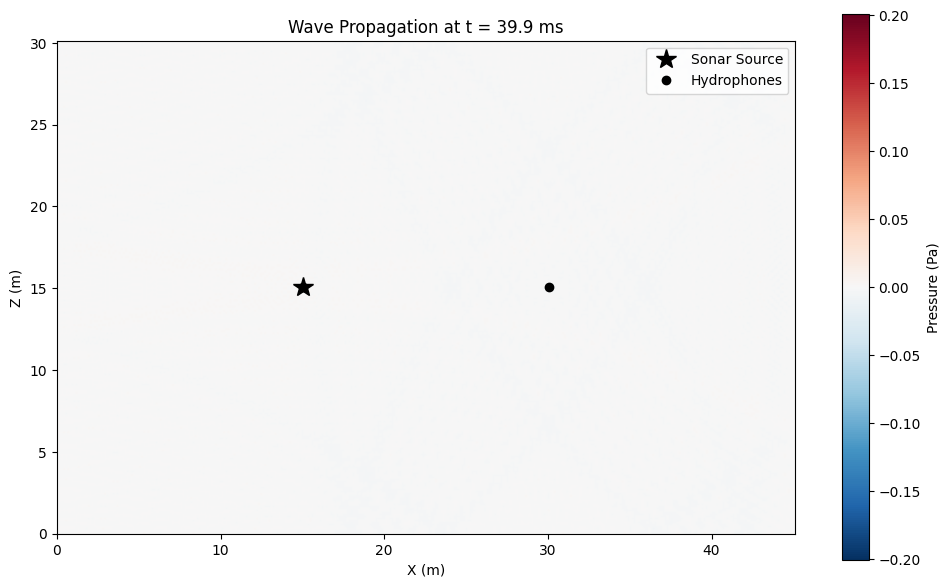


✓ Animation saved as 'POD_reference_wave.gif'


In [34]:
# Create animation of wave propagation
import create_wave_animation as cwa

print("Creating wave animation (this may take 30-60 seconds)...")
anim = cwa.create_wave_animation(X_ref, t_ref, p, save_filename='POD_reference_wave.gif')
print("\n✓ Animation saved as 'POD_reference_wave.gif'")

Computing hydrophone responses...


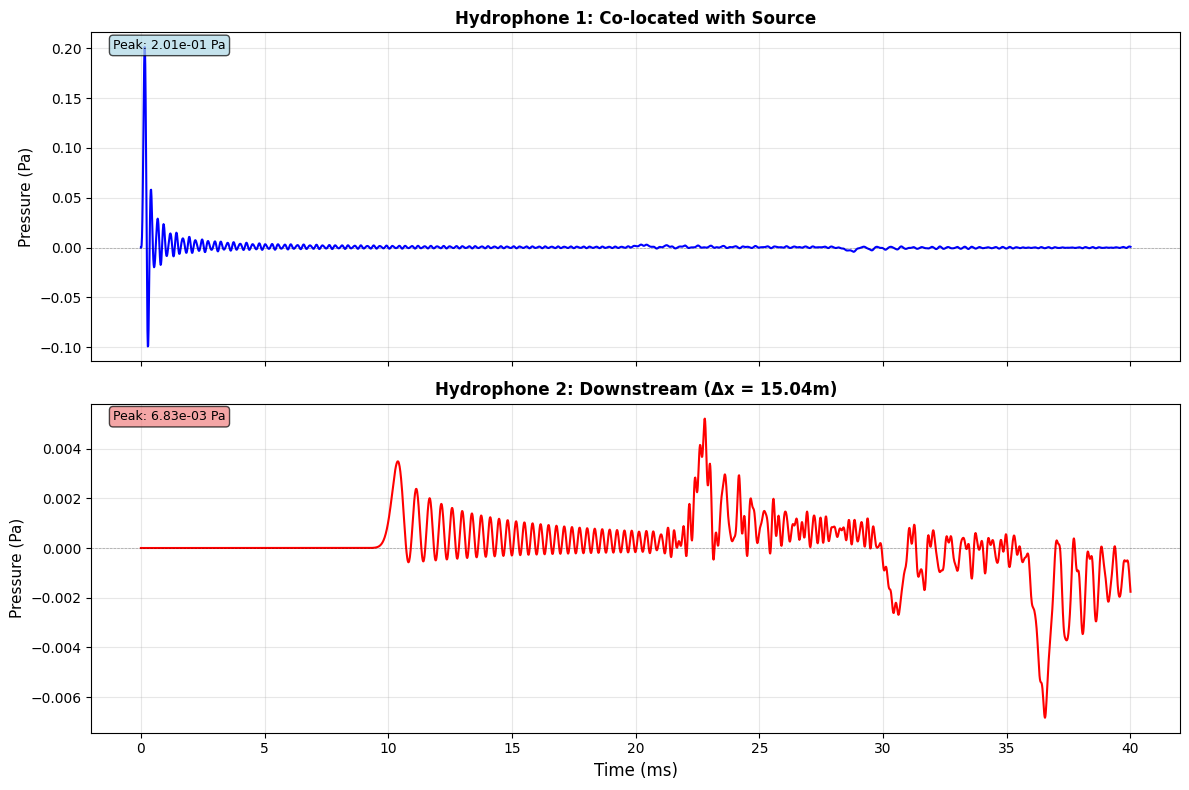

✓ Hydrophone responses computed: 2709 samples × 2 hydrophones
✓ Hydrophone 1 peak: 2.009e-01 Pa
✓ Hydrophone 2 peak: 6.827e-03 Pa
✓ Expected delay: 10.03 ms


In [35]:
# Extract hydrophone output y(t) = C*x(t) for all time steps
print("Computing hydrophone responses...")
y_ref = np.zeros((2, len(t_ref)))  # 2 hydrophones × time samples

for i in range(len(t_ref)):
    y_ref[:, i] = eval_g_Sonar(X_ref[:, i], p).flatten()

# Plot both hydrophone responses
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Hydrophone 1 (co-located with source)
ax1.plot(t_ref * 1000, y_ref[0, :], 'b-', linewidth=1.5)
ax1.set_ylabel('Pressure (Pa)', fontsize=11)
ax1.set_title('Hydrophone 1: Co-located with Source', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linewidth=0.5, linestyle='--', alpha=0.3)
max_p1 = np.max(np.abs(y_ref[0, :]))
ax1.text(0.02, 0.98, f'Peak: {max_p1:.2e} Pa', 
         transform=ax1.transAxes, fontsize=9, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

# Hydrophone 2 (downstream)
ax2.plot(t_ref * 1000, y_ref[1, :], 'r-', linewidth=1.5)
ax2.set_xlabel('Time (ms)', fontsize=12)
ax2.set_ylabel('Pressure (Pa)', fontsize=11)
ax2.set_title(f'Hydrophone 2: Downstream (Δx = {separation_m:.2f}m)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linewidth=0.5, linestyle='--', alpha=0.3)
max_p2 = np.max(np.abs(y_ref[1, :]))
ax2.text(0.02, 0.98, f'Peak: {max_p2:.2e} Pa', 
         transform=ax2.transAxes, fontsize=9, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

plt.tight_layout()
plt.show()

print(f"✓ Hydrophone responses computed: {y_ref.shape[1]} samples × 2 hydrophones")
print(f"✓ Hydrophone 1 peak: {max_p1:.3e} Pa")
print(f"✓ Hydrophone 2 peak: {max_p2:.3e} Pa")
print(f"✓ Expected delay: {separation_m/1500*1e3:.2f} ms")

## Multi-Frequency Snapshot Collection for POD

In [59]:
# ============================================================
# MULTI-FREQUENCY SNAPSHOT COLLECTION
# ============================================================
import os

# CONTROL FLAG: Set to False to skip simulation and load from saved data
RUN_SNAPSHOT_COLLECTION = False

frequencies_Hz = [1000, 2000, 3000, 4000, 5000, 6000]  # 1-6 kHz range
snapshot_spacing = 1  # KEEP EVERY TIMESTEP - no subsampling for proper temporal dynamics!
save_dir = "PODsample_fullres"

# Helper functions for save/load
def save_snapshots(X_pod, y_pod, frequencies, save_dir="PODsample_fullres"):
    """Save snapshot matrices to disk for reuse."""
    os.makedirs(save_dir, exist_ok=True)
    
    np.save(os.path.join(save_dir, "X_pod.npy"), X_pod)
    np.save(os.path.join(save_dir, "y_pod.npy"), y_pod)
    np.save(os.path.join(save_dir, "frequencies.npy"), np.array(frequencies))
    
    # Save metadata
    metadata = {
        'shape_X': X_pod.shape,
        'shape_y': y_pod.shape,
        'frequencies': frequencies,
        'grid': (Nx, Nz),
        'domain': (Lx, Lz),
        'snapshot_spacing': snapshot_spacing,
        'dt': dt,
        'num_steps': num_steps
    }
    np.save(os.path.join(save_dir, "metadata.npy"), metadata)
    
    print(f"✓ Saved snapshots to '{save_dir}/' directory")
    print(f"  - X_pod.npy: {X_pod.nbytes/1e6:.1f} MB")
    print(f"  - y_pod.npy: {y_pod.nbytes/1e6:.1f} MB")

def load_snapshots(save_dir="PODsample_fullres"):
    """Load previously saved snapshot matrices."""
    X_pod = np.load(os.path.join(save_dir, "X_pod.npy"))
    y_pod = np.load(os.path.join(save_dir, "y_pod.npy"))
    metadata = np.load(os.path.join(save_dir, "metadata.npy"), allow_pickle=True).item()
    
    print(f"✓ Loaded snapshots from '{save_dir}/' directory")
    print(f"  - X_pod: {X_pod.shape} ({X_pod.nbytes/1e6:.1f} MB)")
    print(f"  - y_pod: {y_pod.shape} ({y_pod.nbytes/1e6:.1f} MB)")
    print(f"  - Frequencies: {metadata['frequencies']} Hz")
    print(f"  - Grid: {metadata['grid']}, Domain: {metadata['domain']} m")
    
    return X_pod, y_pod, metadata

# Main execution logic
if RUN_SNAPSHOT_COLLECTION:
    print(f"Collecting FULL RESOLUTION snapshots from {len(frequencies_Hz)} frequency simulations...")
    print(f"Frequencies: {frequencies_Hz} Hz")
    print(f"⚠️  NO SUBSAMPLING - keeping all {num_steps+1} timesteps per frequency\n")

    X_snapshots = []
    y_snapshots = []
    total_time = 0

    for i, freq in enumerate(frequencies_Hz):
        print(f"{'='*60}")
        print(f"[{i+1}/{len(frequencies_Hz)}] Running {freq} Hz simulation...")
        
        # Create input function for this frequency
        # Gaussian envelope with ~3-5 cycles at current frequency
        def eval_u_freq(t):
            f0 = freq
            A0 = amplitude_scale
            n_cycles = 3
            sigma = n_cycles / (2 * f0)  # Pulse width for n cycles
            t0 = 3 * sigma  # Center pulse after 3 sigma
            
            envelope = np.exp(-(t - t0)**2 / (2 * sigma**2))
            
            # Only active within 4 sigma
            if abs(t - t0) > 4 * sigma:
                return 0.0
            
            return A0 * envelope * np.sin(2 * np.pi * f0 * t)
        
        # Run simulation
        t0_sim = time.perf_counter()
        X_freq, t_freq = LeapfrogSolver(
            eval_f_Sonar, 
            x_start, 
            p, 
            eval_u_freq, 
            num_steps, 
            dt, 
            visualize=False, 
            verbose=False
        )
        sim_time = time.perf_counter() - t0_sim
        total_time += sim_time
        
        # NO SUBSAMPLING - keep all timesteps
        X_snapshots.append(X_freq)
        
        # Also collect hydrophone outputs for this frequency
        y_freq = np.zeros((2, X_freq.shape[1]))
        for j in range(X_freq.shape[1]):
            y_freq[:, j] = eval_g_Sonar(X_freq[:, j], p).flatten()
        y_snapshots.append(y_freq)
        
        print(f"  ✓ Complete in {sim_time:.1f}s")
        print(f"  ✓ Collected {X_freq.shape[1]} snapshots ({X_freq.nbytes/1e6:.1f} MB")
        print(f"  ✓ Hydrophone peak: {np.max(np.abs(y_freq)):.2e} Pa")

    # Concatenate all snapshots horizontally
    X_pod = np.hstack(X_snapshots)
    y_pod = np.hstack(y_snapshots)

    print(f"\n{'='*60}")
    print(f"SNAPSHOT COLLECTION COMPLETE")
    print(f"{'='*60}")
    print(f"✓ Total snapshots: {X_pod.shape[1]} ({len(frequencies_Hz)} frequencies × {num_steps+1} each)")
    print(f"✓ Snapshot matrix: {X_pod.shape} ({X_pod.nbytes/1e6:.1f} MB)")
    print(f"✓ Output matrix: {y_pod.shape} ({y_pod.nbytes/1e6:.1f} MB)")
    print(f"✓ Total simulation time: {total_time:.1f}s ({total_time/60:.1f} min)")
    
    # Save snapshots for future use
    save_snapshots(X_pod, y_pod, frequencies_Hz, save_dir)
    
    print(f"\n✓ Ready for SVD/POD analysis!")

else:
    print("⊘ RUN_SNAPSHOT_COLLECTION = False")
    print(f"Loading snapshots from '{save_dir}/' directory...\n")
    
    X_pod, y_pod, metadata = load_snapshots(save_dir)
    
    print(f"\n✓ Ready for SVD/POD analysis!")

Frequencies: [1000, 2000, 3000, 4000, 5000, 6000] Hz
⚠️  NO SUBSAMPLING - keeping all 2709 timesteps per frequency

[1/6] Running 1000 Hz simulation...
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 2707 leapfrog steps...
Bootstrapping with first step...
Running 2707 leapfrog steps...
Leapfrog integration complete!
  ✓ Complete in 29.3s
  ✓ Collected 2709 snapshots (3744.9 MB
  ✓ Hydrophone peak: 2.07e-01 Pa
[2/6] Running 2000 Hz simulation...
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 2707 leapfrog steps...
Leapfrog integration complete!
  ✓ Complete in 29.3s
  ✓ Collected 2709 snapshots (3744.9 MB
  ✓ Hydrophone peak: 2.07e-01 Pa
[2/6] Running 2000 Hz simulation...
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 2707 leapfrog steps...
Leapfrog integration complete!
  ✓ Complete in 29.8s
  ✓ Collected 2709 snapshots (3744.9 MB
  ✓ Hydrop

In [60]:
# ============================================================
# LOAD AND VISUALIZE SNAPSHOTS
# ============================================================

# Load the saved snapshots
X_loaded, y_loaded, meta = load_snapshots(save_dir)

print(f"\n{'='*60}")
print(f"SNAPSHOT DATA STRUCTURE")
print(f"{'='*60}")
print(f"X_pod shape: {X_loaded.shape}")
print(f"  - State dimension: {X_loaded.shape[0]} (should be 2×Nx×Nz = {2*Nx*Nz})")
print(f"  - Total snapshots: {X_loaded.shape[1]}")
print(f"  - Snapshots per frequency: ~{X_loaded.shape[1]//len(frequencies_Hz)}")
print(f"\ny_pod shape: {y_loaded.shape}")
print(f"  - Hydrophones: {y_loaded.shape[0]}")
print(f"  - Time samples: {y_loaded.shape[1]}")
print(f"\nMetadata:")
print(f"  - Frequencies: {meta['frequencies']} Hz")
print(f"  - Grid: {meta['grid']}")
print(f"  - Domain: {meta['domain']} m")
print(f"  - Snapshot spacing: every {meta['snapshot_spacing']}th timestep")

# Calculate snapshots per frequency (they should all be the same)
n_snaps_per_freq = X_loaded.shape[1] // len(frequencies_Hz)
print(f"\n{'='*60}")
print(f"SNAPSHOT DISTRIBUTION")
print(f"{'='*60}")

# Since snapshots are concatenated, we need to figure out where each frequency starts/ends
# They should be in order: [1kHz snapshots | 2kHz snapshots | ... | 6kHz snapshots]
for i, freq in enumerate(frequencies_Hz):
    start_idx = i * n_snaps_per_freq
    end_idx = (i + 1) * n_snaps_per_freq if i < len(frequencies_Hz)-1 else X_loaded.shape[1]
    
    # Get snapshots for this frequency
    X_freq_snaps = X_loaded[:, start_idx:end_idx]
    y_freq_snaps = y_loaded[:, start_idx:end_idx]
    
    # Compute statistics
    max_state = np.max(np.abs(X_freq_snaps))
    max_pressure_h1 = np.max(np.abs(y_freq_snaps[0, :]))
    max_pressure_h2 = np.max(np.abs(y_freq_snaps[1, :]))
    
    print(f"{freq:4d} Hz: snapshots [{start_idx:4d}:{end_idx:4d}] = {end_idx-start_idx:3d} samples")
    print(f"         Max |x|: {max_state:.2e}, Max |y1|: {max_pressure_h1:.2e}, Max |y2|: {max_pressure_h2:.2e}")


✓ Loaded snapshots from 'PODsample_fullres/' directory
  - X_pod: (172800, 16254) (22469.5 MB)
  - y_pod: (2, 16254) (0.3 MB)
  - Frequencies: [1000, 2000, 3000, 4000, 5000, 6000] Hz
  - Grid: (360, 240), Domain: (45.0, 30.0) m

SNAPSHOT DATA STRUCTURE
X_pod shape: (172800, 16254)
  - State dimension: 172800 (should be 2×Nx×Nz = 172800)
  - Total snapshots: 16254
  - Snapshots per frequency: ~2709

y_pod shape: (2, 16254)
  - Hydrophones: 2
  - Time samples: 16254

Metadata:
  - Frequencies: [1000, 2000, 3000, 4000, 5000, 6000] Hz
  - Grid: (360, 240)
  - Domain: (45.0, 30.0) m
  - Snapshot spacing: every 1th timestep

SNAPSHOT DISTRIBUTION
1000 Hz: snapshots [   0:2709] = 2709 samples
         Max |x|: 1.30e+03, Max |y1|: 2.07e-01, Max |y2|: 1.38e-02
1000 Hz: snapshots [   0:2709] = 2709 samples
         Max |x|: 1.30e+03, Max |y1|: 2.07e-01, Max |y2|: 1.38e-02
2000 Hz: snapshots [2709:5418] = 2709 samples
         Max |x|: 2.32e+03, Max |y1|: 1.85e-01, Max |y2|: 7.97e-03
2000 Hz: sna

1000 Hz - H1 peak: 2.07e-01 Pa, H2 peak: 1.38e-02 Pa, Ratio: 0.067
3000 Hz - H1 peak: 2.05e-01 Pa, H2 peak: 3.88e-03 Pa, Ratio: 0.019
6000 Hz - H1 peak: 1.28e-01 Pa, H2 peak: 5.73e-04 Pa, Ratio: 0.004


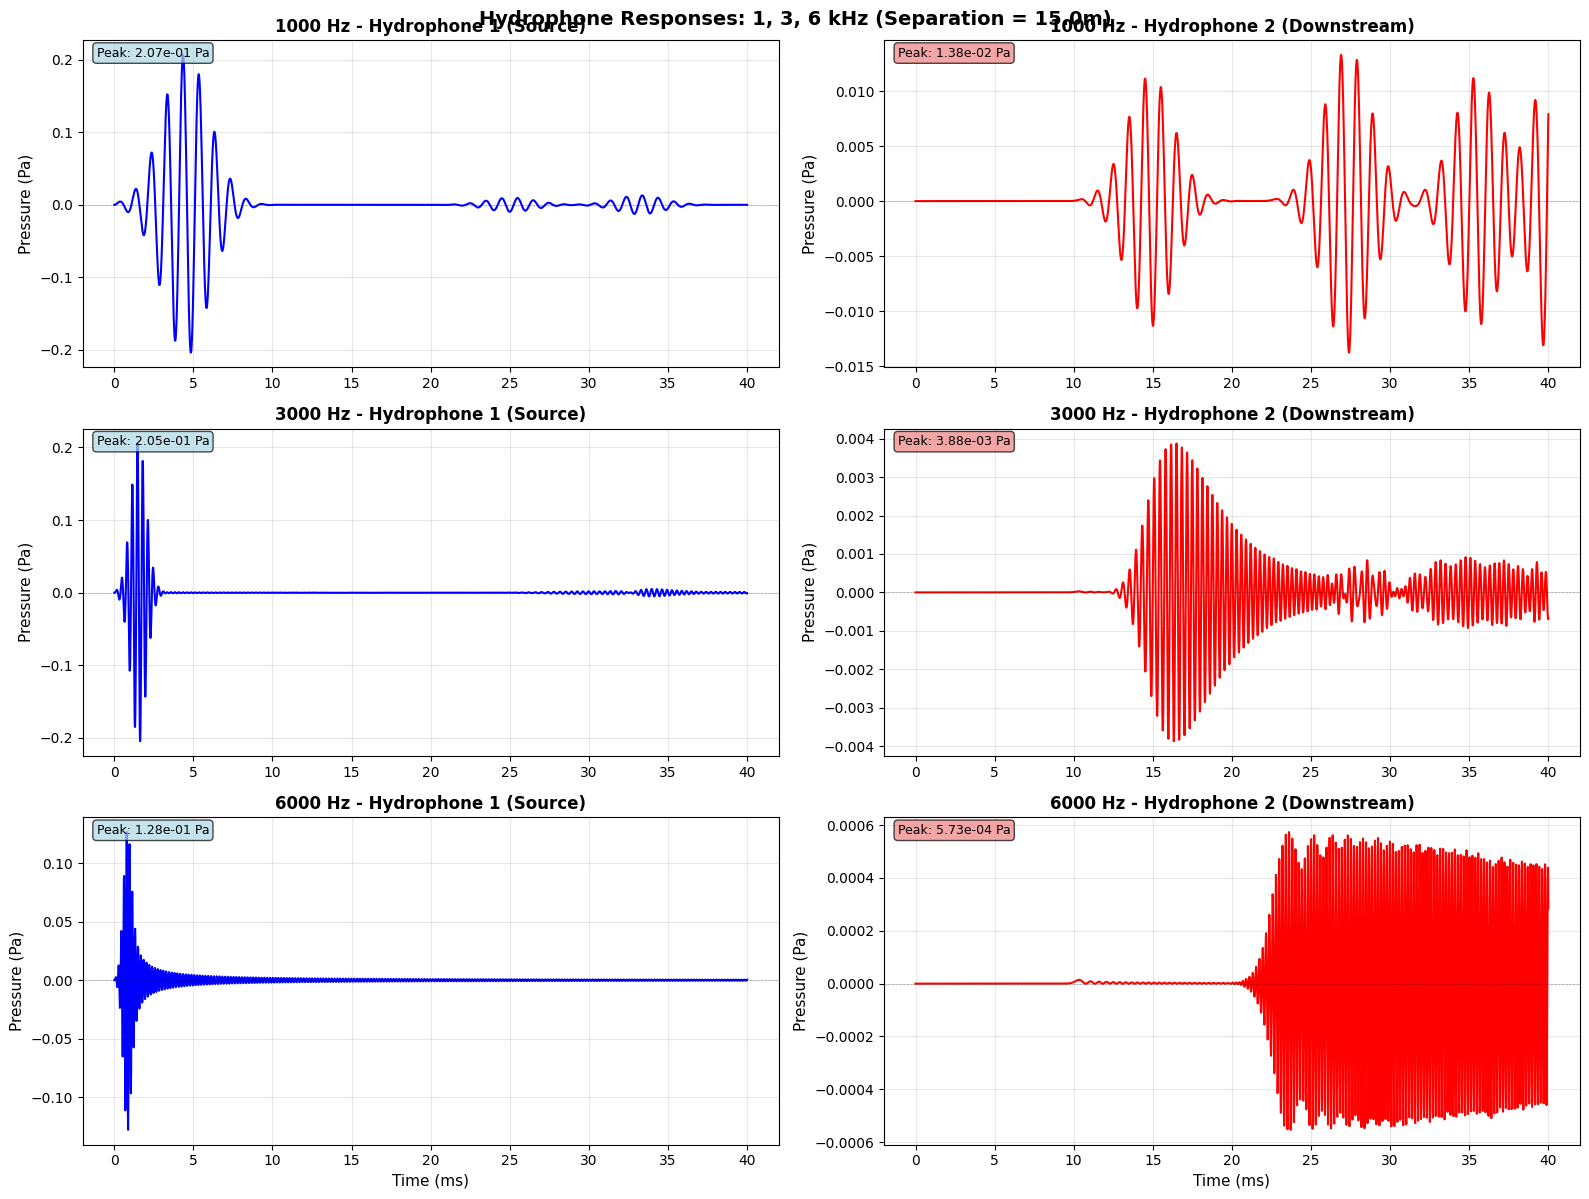


✓ Plotted hydrophone responses for [1000, 3000, 6000] Hz
✓ Time resolution: 14.8 μs between snapshots
✓ Duration per frequency: 40.0 ms
✓ Expected delay between hydrophones: 10.03 ms


In [61]:
# ============================================================
# PLOT HYDROPHONE RESPONSES FOR SELECTED FREQUENCIES
# ============================================================

# Plot 1, 3, and 6 kHz with separate columns for each hydrophone
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Reconstruct time vector (approximate since we subsampled)
# Each simulation was t_sim = 40ms with dt ≈ 30μs
# With snapshot_spacing = 10, effective dt_snapshot ≈ 300μs
dt_snapshot = dt * snapshot_spacing
n_snaps_per_freq = X_loaded.shape[1] // len(frequencies_Hz)
t_snapshot = np.arange(n_snaps_per_freq) * dt_snapshot * 1000  # Convert to ms

# Select frequencies to plot: 1, 3, 6 kHz (indices 0, 2, 5)
freq_indices = [0, 2, 5]
selected_freqs = [frequencies_Hz[i] for i in freq_indices]

for plot_row, freq_idx in enumerate(freq_indices):
    freq = frequencies_Hz[freq_idx]
    
    # Extract snapshots for this frequency
    start_idx = freq_idx * n_snaps_per_freq
    end_idx = (freq_idx + 1) * n_snaps_per_freq if freq_idx < len(frequencies_Hz)-1 else X_loaded.shape[1]
    y_freq = y_loaded[:, start_idx:end_idx]
    
    # Left column: Hydrophone 1 (co-located with source)
    ax_left = axes[plot_row, 0]
    ax_left.plot(t_snapshot[:y_freq.shape[1]], y_freq[0, :], 'b-', linewidth=1.5)
    ax_left.set_ylabel('Pressure (Pa)', fontsize=11)
    ax_left.set_title(f'{freq} Hz - Hydrophone 1 (Source)', fontsize=12, fontweight='bold')
    ax_left.grid(True, alpha=0.3)
    ax_left.axhline(y=0, color='k', linewidth=0.5, linestyle='--', alpha=0.3)
    
    max_p1 = np.max(np.abs(y_freq[0, :]))
    ax_left.text(0.02, 0.98, f'Peak: {max_p1:.2e} Pa', 
                 transform=ax_left.transAxes, fontsize=9, 
                 verticalalignment='top', 
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    if plot_row == 2:  # Bottom row
        ax_left.set_xlabel('Time (ms)', fontsize=11)
    
    # Right column: Hydrophone 2 (downstream)
    ax_right = axes[plot_row, 1]
    ax_right.plot(t_snapshot[:y_freq.shape[1]], y_freq[1, :], 'r-', linewidth=1.5)
    ax_right.set_ylabel('Pressure (Pa)', fontsize=11)
    ax_right.set_title(f'{freq} Hz - Hydrophone 2 (Downstream)', fontsize=12, fontweight='bold')
    ax_right.grid(True, alpha=0.3)
    ax_right.axhline(y=0, color='k', linewidth=0.5, linestyle='--', alpha=0.3)
    
    max_p2 = np.max(np.abs(y_freq[1, :]))
    ax_right.text(0.02, 0.98, f'Peak: {max_p2:.2e} Pa', 
                  transform=ax_right.transAxes, fontsize=9, 
                  verticalalignment='top', 
                  bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
    
    if plot_row == 2:  # Bottom row
        ax_right.set_xlabel('Time (ms)', fontsize=11)
    
    # Print comparison
    print(f"{freq:4d} Hz - H1 peak: {max_p1:.2e} Pa, H2 peak: {max_p2:.2e} Pa, Ratio: {max_p2/max_p1:.3f}")

plt.tight_layout()
plt.suptitle(f'Hydrophone Responses: 1, 3, 6 kHz (Separation = {separation_m:.1f}m)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.subplots_adjust(top=0.97)
plt.show()

print(f"\n✓ Plotted hydrophone responses for {selected_freqs} Hz")
print(f"✓ Time resolution: {dt_snapshot*1e6:.1f} μs between snapshots")
print(f"✓ Duration per frequency: {t_snapshot[-1]:.1f} ms")
print(f"✓ Expected delay between hydrophones: {separation_m/1500*1e3:.2f} ms")


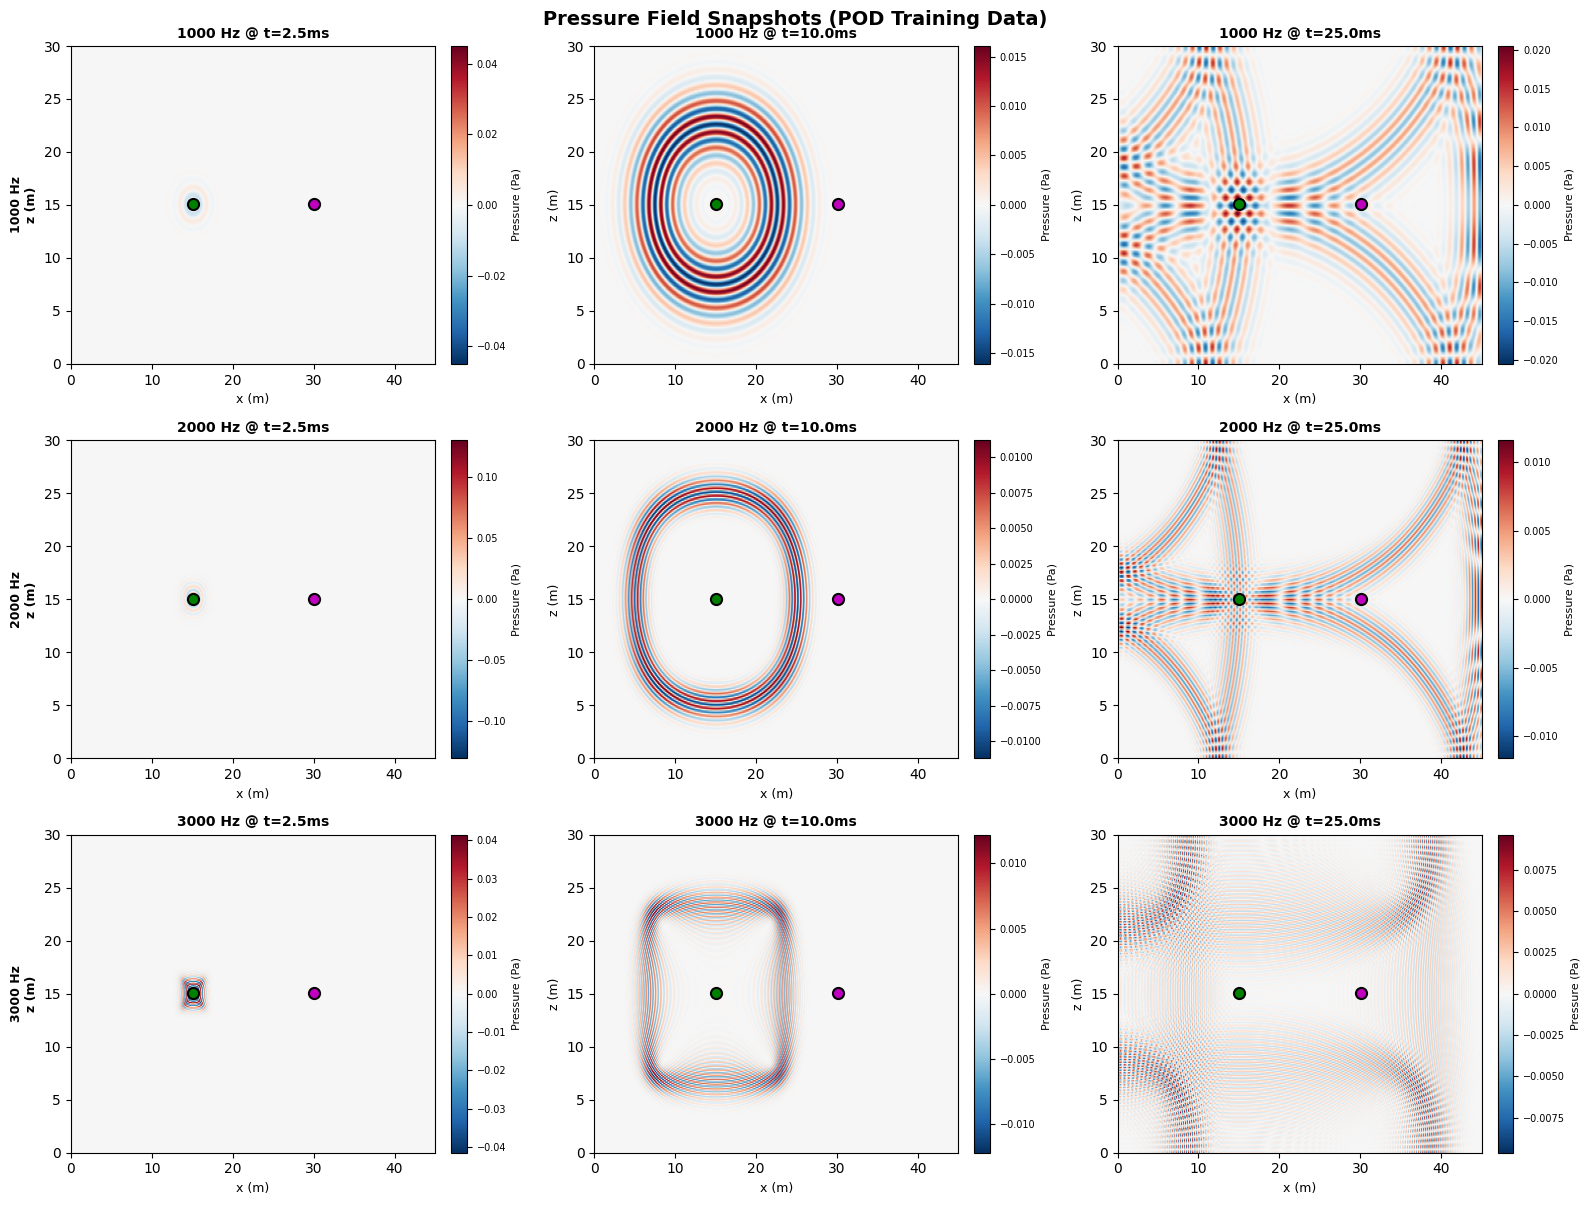


✓ Visualized spatial snapshots for first 3 frequencies
✓ Showing snapshots at t = [2.5, 10.0, 25.0] ms
✓ Green marker = Hydrophone 1 (co-located with source)
✓ Magenta marker = Hydrophone 2 (downstream)


In [62]:
# ============================================================
# VISUALIZE SPATIAL SNAPSHOTS (WAVE FIELDS)
# ============================================================

# Pick a few representative snapshots from each frequency to visualize
# We'll show the pressure field (first half of state vector)

fig, axes = plt.subplots(3, 3, figsize=(16, 12))

# Snapshot times in ms: 2.5, 10, 25 ms
snapshot_times_ms = [2.5, 10.0, 25.0]
snapshot_times = [int(t_ms / (dt_snapshot * 1000)) for t_ms in snapshot_times_ms]  # Convert to indices

for freq_idx in range(3):  # Show first 3 frequencies (1, 2, 3 kHz)
    freq = frequencies_Hz[freq_idx]
    
    for snap_idx, t_idx in enumerate(snapshot_times):
        ax = axes[freq_idx, snap_idx]
        
        # Get snapshot index in full array
        start_idx = freq_idx * n_snaps_per_freq
        global_idx = start_idx + t_idx
        
        # Extract pressure field (first N elements of state vector)
        p_field = X_loaded[:N, global_idx].reshape(Nx, Nz)
        
        # Plot as 2D heatmap
        im = ax.imshow(p_field.T, origin='lower', aspect='auto', 
                       extent=[0, Lx, 0, Lz], cmap='RdBu_r',
                       vmin=-np.max(np.abs(p_field)), vmax=np.max(np.abs(p_field)))
        
        # Mark hydrophone locations
        h1_x = hydro_1_x * p['dx']
        h2_x = hydro_2_x * p['dx']
        h_z = p['sonar_iz'] * p['dz']
        ax.plot([h1_x], [h_z], 'go', markersize=8, markeredgecolor='k', markeredgewidth=1.5, label='H1')
        ax.plot([h2_x], [h_z], 'mo', markersize=8, markeredgecolor='k', markeredgewidth=1.5, label='H2')
        
        time_ms = snapshot_times_ms[snap_idx]
        ax.set_title(f'{freq} Hz @ t={time_ms:.1f}ms', fontsize=10, fontweight='bold')
        ax.set_xlabel('x (m)', fontsize=9)
        
        if snap_idx == 0:
            ax.set_ylabel(f'{freq} Hz\nz (m)', fontsize=9, fontweight='bold')
        else:
            ax.set_ylabel('z (m)', fontsize=9)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Pressure (Pa)', fontsize=8)
        cbar.ax.tick_params(labelsize=7)

plt.tight_layout()
plt.suptitle('Pressure Field Snapshots (POD Training Data)', 
             fontsize=14, fontweight='bold', y=1.00)
plt.subplots_adjust(top=0.97)
plt.show()

print(f"\n✓ Visualized spatial snapshots for first 3 frequencies")
print(f"✓ Showing snapshots at t = {snapshot_times_ms} ms")
print(f"✓ Green marker = Hydrophone 1 (co-located with source)")
print(f"✓ Magenta marker = Hydrophone 2 (downstream)")


## SVD/POD Analysis

**Note:** Assumes cells 9-11 have been run (loading snapshots and computing frequency distribution)

In [ ]:
# diagnostic:
print(f"X_loaded stats:")
print(f"  Shape: {X_loaded.shape}")
print(f"  Dtype: {X_loaded.dtype}")
print(f"  Has NaN: {np.any(np.isnan(X_loaded))}")
print(f"  Has Inf: {np.any(np.isinf(X_loaded))}")
print(f"  Max: {np.max(np.abs(X_loaded)):.3e}")
print(f"  Sample values: {X_loaded[:5, 0]}")

X_loaded stats:
  Shape: (172800, 16254)
  Dtype: float64
  Has NaN: False
  Has NaN: False
  Has Inf: False
  Has Inf: False
  Max: 6.625e+03
  Sample values: [ 1.25730221e-11 -1.32104863e-11  6.40422650e-11  1.04900117e-11
 -5.35669373e-11]
  Max: 6.625e+03
  Sample values: [ 1.25730221e-11 -1.32104863e-11  6.40422650e-11  1.04900117e-11
 -5.35669373e-11]


In [77]:
# ============================================================
# PERFORM SVD ON SNAPSHOT MATRIX WITH PROPER PRESSURE-VELOCITY SCALING
# ============================================================
# Note: Assumes cells 9-12 have been run where we loaded X_loaded, y_loaded, 
# and computed n_snaps_per_freq for frequency distribution

from sklearn.utils.extmath import randomized_svd

print("=" * 80)
print("PERFORMING SVD WITH PHYSICAL SCALING")
print("=" * 80)
print(f"X_loaded shape: {X_loaded.shape}")
print(f"  - State dimension: {X_loaded.shape[0]}")
print(f"  - Number of snapshots: {X_loaded.shape[1]}")
print(f"  - Matrix size: {X_loaded.shape[0] * X_loaded.shape[1]:,} elements ({X_loaded.nbytes/1e9:.2f} GB)")
print(f"  - Data type: {X_loaded.dtype}")

# ============================================================
# CRITICAL: Scale pressure and velocity to comparable magnitudes
# ============================================================
# The state vector x = [p; v] mixes pressure (Pa) and velocity (m/s)
# These have vastly different magnitudes, which breaks POD basis quality
# and causes the ROM projection to have unstable eigenvalues

N = Nx * Nz  # Number of spatial points

# Split snapshots into pressure and velocity components
p_snapshots = X_loaded[:N, :]      # Pressure field (first N states)
v_snapshots = X_loaded[N:, :]      # Velocity field (second N states)

print(f"\n{'─'*80}")
print("COMPUTING SCALING FACTORS")
print("─" * 80)

# Compute characteristic scales using standard deviation (RMS-like measure)
p_scale = np.std(p_snapshots)  # Characteristic pressure variation
v_scale = np.std(v_snapshots)  # Characteristic velocity variation

print(f"Pressure component:")
print(f"  - Mean: {np.mean(p_snapshots):.3e} Pa")
print(f"  - Std:  {p_scale:.3e} Pa  ← scaling factor")
print(f"  - Max:  {np.max(np.abs(p_snapshots)):.3e} Pa")

print(f"\nVelocity component:")
print(f"  - Mean: {np.mean(v_snapshots):.3e} m/s")
print(f"  - Std:  {v_scale:.3e} m/s  ← scaling factor")
print(f"  - Max:  {np.max(np.abs(v_snapshots)):.3e} m/s")

print(f"\nMagnitude ratio: p_scale / v_scale = {p_scale/v_scale:.3e}")
print(f"⚠️  Without scaling, POD would be dominated by {'pressure' if p_scale > v_scale else 'velocity'}!")

# Create scaled snapshot matrix
print(f"\n{'─'*80}")
print("SCALING SNAPSHOTS TO UNIT VARIANCE")
print("─" * 80)

X_scaled = np.zeros_like(X_loaded)
X_scaled[:N, :] = p_snapshots / p_scale   # Normalize pressure
X_scaled[N:, :] = v_snapshots / v_scale   # Normalize velocity

# Verify scaling worked
print(f"Scaled snapshot statistics:")
print(f"  - Pressure part: mean={np.mean(X_scaled[:N, :]):.3e}, std={np.std(X_scaled[:N, :]):.3f} (target: ~1.0)")
print(f"  - Velocity part: mean={np.mean(X_scaled[N:, :]):.3e}, std={np.std(X_scaled[N:, :]):.3f} (target: ~1.0)")
print(f"✓ Both components now have comparable magnitudes!")

# ============================================================
# PERFORM RANDOMIZED SVD ON SCALED DATA
# ============================================================
n_components = min(2000, X_scaled.shape[1])  # Can't have more components than snapshots

print(f"\n{'─'*80}")
print(f"RUNNING RANDOMIZED SVD ON SCALED SNAPSHOTS")
print("─" * 80)
print(f"Computing first {n_components} singular values/vectors...")
print(f"This will take 4-6 minutes...\n")

t0 = time.perf_counter()

# Randomized SVD: much faster for large matrices, keeps first k components
# U_scaled: spatial modes for SCALED data (172800 × n_components)
# Sigma: singular values (n_components,)
# VT: temporal coefficients (n_components × 16254)
U_scaled, Sigma, VT = randomized_svd(
    X_scaled,  # ← Using SCALED snapshots!
    n_components=n_components,
    n_iter=5,  # Number of power iterations (higher = more accurate)
    random_state=42  # For reproducibility
)

svd_time = time.perf_counter() - t0

print(f"✓ Randomized SVD complete in {svd_time:.2f}s ({svd_time/60:.1f} min)")

# ============================================================
# UN-SCALE POD MODES BACK TO PHYSICAL UNITS
# ============================================================
print(f"\n{'─'*80}")
print("RESTORING POD MODES TO PHYSICAL UNITS")
print("─" * 80)

# Create unscaled POD basis: multiply each component by its scale
U = np.zeros_like(U_scaled)
U[:N, :] = U_scaled[:N, :] * p_scale    # Pressure modes (Pa)
U[N:, :] = U_scaled[N:, :] * v_scale    # Velocity modes (m/s)

print(f"Physical POD modes:")
print(f"  - Pressure modes: min={np.min(U[:N, :]):.3e}, max={np.max(U[:N, :]):.3e} Pa")
print(f"  - Velocity modes: min={np.min(U[N:, :]):.3e}, max={np.max(U[N:, :]):.3e} m/s")
print(f"✓ POD basis restored to physical units!")

# ============================================================
# VERIFY SVD RESULTS
# ============================================================
print(f"\n{'─'*80}")
print("SVD VALIDATION")
print("─" * 80)
print(f"  U shape: {U.shape} (spatial POD modes in physical units)")
print(f"  Sigma shape: {Sigma.shape} (singular values)")
print(f"  VT shape: {VT.shape} (temporal coefficients)")

print(f"\nSingular value validation:")
print(f"  σ_max (σ[0]): {Sigma[0]:.3e}")
print(f"  σ_min (σ[-1]): {Sigma[-1]:.3e}")
print(f"  Condition number: {Sigma[0]/Sigma[-1]:.3e}")
print(f"  σ[0] > σ[-1]: {Sigma[0] > Sigma[-1]}")  # Should be True
print(f"  First 10 σ values: {Sigma[:10]}")

if Sigma[0] < Sigma[-1] or Sigma[0] < 1e-10:
    print("\n⚠️  ERROR: Singular values look incorrect!")
    print("Try increasing n_iter or check data scaling.")
else:
    # Compute cumulative energy capture
    energy = Sigma**2
    total_energy = np.sum(energy)
    cumulative_energy = np.cumsum(energy) / total_energy
    
    print(f"\n{'─'*80}")
    print("ENERGY DISTRIBUTION")
    print("─" * 80)
    print(f"  Total energy (Σσ²): {total_energy:.3e}")
    print(f"  Energy in first 100 modes: {cumulative_energy[99]*100:.2f}%")
    print(f"  Energy in first 500 modes: {cumulative_energy[min(499, len(Sigma)-1)]*100:.2f}%")
    print(f"  Energy in all {len(Sigma)} modes: {cumulative_energy[-1]*100:.2f}%")
    
    # Find number of modes for various energy thresholds
    thresholds = [0.90, 0.95, 0.99, 0.999, 0.9999]
    print(f"\nModes needed for energy capture:")
    for thresh in thresholds:
        n_modes = np.searchsorted(cumulative_energy, thresh) + 1
        if n_modes <= len(Sigma):
            print(f"  {thresh*100:5.2f}% energy: q = {n_modes:4d} modes ({n_modes/len(Sigma)*100:.2f}% of total)")
        else:
            print(f"  {thresh*100:5.2f}% energy: > {len(Sigma)} modes (need more components)")

print(f"\n{'='*80}")
print("✓ SCALED SVD COMPLETE - POD BASIS READY FOR ROM CONSTRUCTION")
print("=" * 80)
print(f"The POD modes (U) are now in physical units and properly balanced.")
print(f"Eigenvalues of ROM matrices should be much more stable!")


PERFORMING SVD WITH PHYSICAL SCALING
X_loaded shape: (172800, 16254)
  - State dimension: 172800
  - Number of snapshots: 16254
  - Matrix size: 2,808,691,200 elements (22.47 GB)
  - Data type: float64

────────────────────────────────────────────────────────────────────────────────
COMPUTING SCALING FACTORS
────────────────────────────────────────────────────────────────────────────────
Pressure component:
Pressure component:
  - Mean: 1.934e-06 Pa
  - Std:  2.170e-03 Pa  ← scaling factor
  - Mean: 1.934e-06 Pa
  - Std:  2.170e-03 Pa  ← scaling factor
  - Max:  2.721e-01 Pa

Velocity component:
  - Max:  2.721e-01 Pa

Velocity component:
  - Mean: -1.249e-04 m/s
  - Std:  2.960e+01 m/s  ← scaling factor
  - Mean: -1.249e-04 m/s
  - Std:  2.960e+01 m/s  ← scaling factor
  - Max:  6.625e+03 m/s

Magnitude ratio: p_scale / v_scale = 7.329e-05
⚠️  Without scaling, POD would be dominated by velocity!

────────────────────────────────────────────────────────────────────────────────
SCALING 

ELBOW POINT DETECTION: Top 10 Largest Relative Drops (10-mode bins)
Rank   Mode Range         σ_start         σ_end           Rel. Drop    Energy %
--------------------------------------------------------------------------------
1       451 - 475       8.747e+00       8.598e-03       0.9990       100.00%
2      1951 - 1975      2.177e-10       4.605e-12       0.9788       100.00%
3       901 - 925       2.402e-03       1.773e-04       0.9262       100.00%
4      1476 - 1500      1.997e-06       2.879e-07       0.8558       100.00%
5      1976 - 2000      4.218e-12       8.429e-13       0.8002       100.00%
6       376 - 400       1.846e+02       4.210e+01       0.7719       100.00%
7       351 - 375       7.017e+02       1.852e+02       0.7361        99.99%
8      1451 - 1475      8.447e-06       2.255e-06       0.7330       100.00%
9      1926 - 1950      6.714e-10       2.220e-10       0.6694       100.00%
10      401 - 425       3.632e+01       1.534e+01       0.5776       100.00%


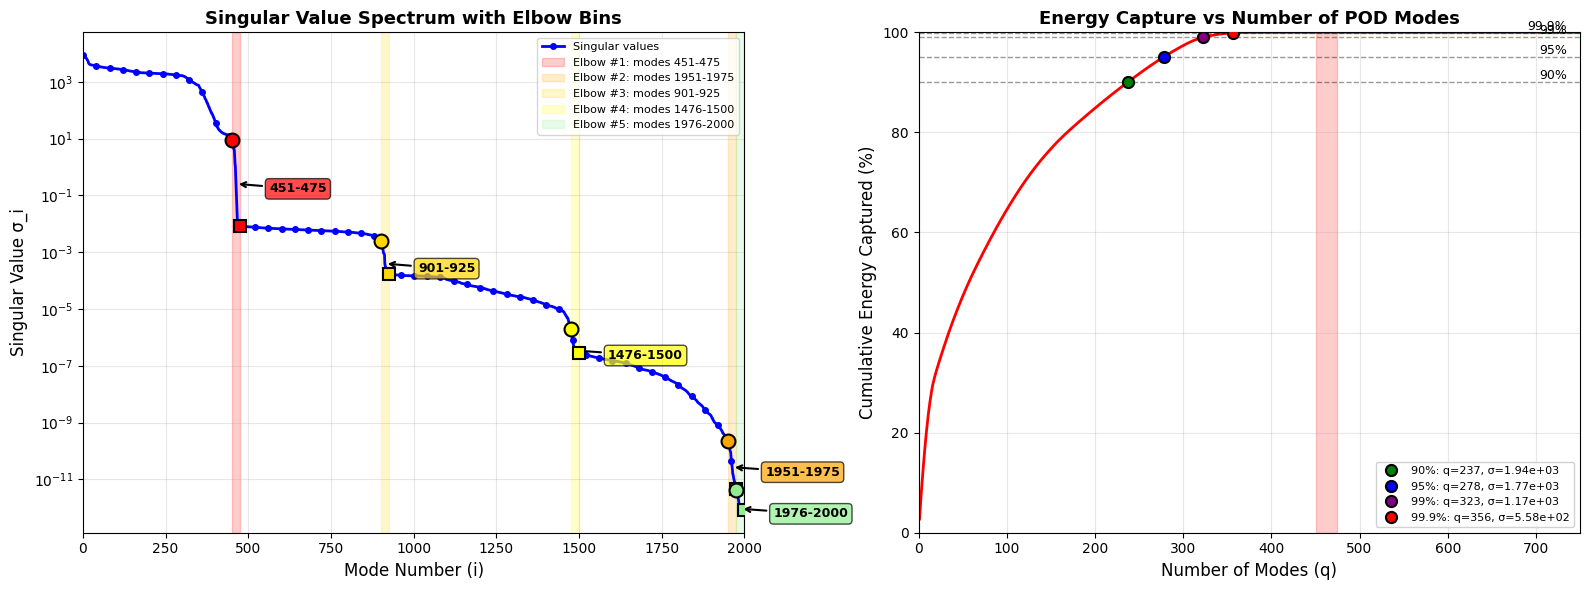


✓ Plotted singular value spectrum and energy capture
✓ Total modes available: 2000
✓ Detected 10 elbow bins using 25-mode binning
✓ Top 5 suggested truncation bins: ['451-475', '1951-1975', '901-925', '1476-1500', '1976-2000']


In [78]:
# ============================================================
# DETECT ELBOW POINTS / DROPS IN SINGULAR VALUE SPECTRUM
# ============================================================

# Bin singular values into groups of 10 and compute average drop per bin
bin_size = 25
n_bins = len(Sigma) // bin_size

# Compute relative drop across each bin: (σ_bin_start - σ_bin_end) / σ_bin_start
bin_drops = np.zeros(n_bins)
bin_start_modes = np.zeros(n_bins, dtype=int)

for i in range(n_bins):
    start_idx = i * bin_size
    end_idx = (i + 1) * bin_size - 1
    
    bin_start_modes[i] = start_idx + 1  # 1-based mode number at start of bin
    
    # Relative drop from start to end of bin
    bin_drops[i] = (Sigma[start_idx] - Sigma[end_idx]) / Sigma[start_idx]

# Find top 10 bins with largest relative drops
top_n_bins = 10
top_bin_indices = np.argsort(bin_drops)[::-1][:top_n_bins]
drop_mode_bins = bin_start_modes[top_bin_indices]

print("=" * 80)
print("ELBOW POINT DETECTION: Top 10 Largest Relative Drops (10-mode bins)")
print("=" * 80)
print(f"{'Rank':<6} {'Mode Range':<18} {'σ_start':<15} {'σ_end':<15} {'Rel. Drop':<12} {'Energy %'}")
print("-" * 80)

for rank, bin_idx in enumerate(top_bin_indices, 1):
    start_mode = bin_start_modes[bin_idx]
    end_mode = start_mode + bin_size - 1
    
    start_idx = (bin_idx) * bin_size
    end_idx = start_idx + bin_size - 1
    
    sigma_start = Sigma[start_idx]
    sigma_end = Sigma[end_idx]
    rel_drop = bin_drops[bin_idx]
    energy_pct = cumulative_energy[end_idx] * 100
    
    print(f"{rank:<6} {start_mode:4d} - {end_mode:<9d} {sigma_start:<15.3e} {sigma_end:<15.3e} {rel_drop:<12.4f} {energy_pct:>6.2f}%")

print("=" * 80)

# ============================================================
# PLOT SINGULAR VALUES WITH ELBOW POINTS MARKED
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Singular values on semi-log scale with elbow points
ax1 = axes[0]
ax1.semilogy(range(1, len(Sigma) + 1), Sigma, 'b-', linewidth=2, marker='o', 
             markersize=4, markevery=max(1, len(Sigma)//50), label='Singular values')
ax1.set_xlabel('Mode Number (i)', fontsize=12)
ax1.set_ylabel('Singular Value σ_i', fontsize=12)
ax1.set_title('Singular Value Spectrum with Elbow Bins', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, which='both')
ax1.set_xlim(0, len(Sigma))

# Mark top 5 elbow bins on the plot
colors = ['red', 'orange', 'gold', 'yellow', 'lightgreen']
for rank in range(min(5, len(drop_mode_bins))):
    start_mode = drop_mode_bins[rank]
    end_mode = start_mode + bin_size - 1
    
    # Highlight the bin range
    start_idx = start_mode - 1
    end_idx = end_mode - 1
    
    # Shade the bin region
    ax1.axvspan(start_mode, end_mode, alpha=0.2, color=colors[rank], 
                label=f'Elbow #{rank+1}: modes {start_mode}-{end_mode}')
    
    # Mark start and end points
    ax1.plot(start_mode, Sigma[start_idx], 'o', color=colors[rank], markersize=10, 
             markeredgecolor='k', markeredgewidth=1.5, zorder=10)
    ax1.plot(end_mode, Sigma[end_idx], 's', color=colors[rank], markersize=8, 
             markeredgecolor='k', markeredgewidth=1.5, zorder=10)
    
    # Add annotation
    mid_mode = (start_mode + end_mode) // 2
    mid_idx = mid_mode - 1
    ax1.annotate(f'{start_mode}-{end_mode}', 
                xy=(mid_mode, Sigma[mid_idx]), 
                xytext=(mid_mode + len(Sigma)*0.05, Sigma[mid_idx]*0.5),
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor=colors[rank], alpha=0.7),
                arrowprops=dict(arrowstyle='->', color='k', lw=1.5))

ax1.legend(loc='upper right', fontsize=8)

# Right plot: Cumulative energy capture with elbow points
ax2 = axes[1]
ax2.plot(range(1, len(Sigma) + 1), cumulative_energy * 100, 'r-', linewidth=2)
ax2.set_xlabel('Number of Modes (q)', fontsize=12)
ax2.set_ylabel('Cumulative Energy Captured (%)', fontsize=12)
ax2.set_title('Energy Capture vs Number of POD Modes', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, min(750, len(Sigma)))  # Extended to 750 modes
ax2.set_ylim(0, 100)

# Add horizontal lines for common thresholds with different colored markers
threshold_colors = {'90': 'green', '95': 'blue', '99': 'purple', '99.9': 'red'}
threshold_markers = []

for thresh in [90, 95, 99, 99.9]:
    ax2.axhline(y=thresh, color='k', linestyle='--', linewidth=1, alpha=0.4)
    n_modes = np.searchsorted(cumulative_energy, thresh/100) + 1
    
    # Get the singular value at this threshold
    if n_modes <= len(Sigma):
        sigma_at_thresh = Sigma[n_modes - 1]
        
        # Position label on right side
        ax2.text(min(750, len(Sigma))*0.98, thresh, f'{thresh}%', 
                fontsize=9, ha='right', va='bottom')
        
        # Mark the point where this threshold is reached with different color
        if n_modes <= min(750, len(Sigma)):
            color = threshold_colors[str(thresh)]
            marker = ax2.plot(n_modes, thresh, 'o', markersize=8, color=color, 
                            markeredgecolor='k', markeredgewidth=1.5, zorder=10,
                            label=f'{thresh}%: q={n_modes}, σ={sigma_at_thresh:.2e}')[0]
            threshold_markers.append(marker)

# Add legend for threshold markers in bottom right
if threshold_markers:
    ax2.legend(loc='lower right', fontsize=8, framealpha=0.9)

# Mark elbow points on energy plot (if within x-range)
for rank in range(min(5, len(drop_mode_bins))):
    start_mode = drop_mode_bins[rank]
    end_mode = start_mode + bin_size - 1
    
    if start_mode <= min(750, len(Sigma)):
        # Shade the bin region on energy plot
        if end_mode <= min(750, len(Sigma)):
            ax2.axvspan(start_mode, end_mode, alpha=0.2, color=colors[rank])
        else:
            ax2.axvspan(start_mode, min(750, len(Sigma)), alpha=0.2, color=colors[rank])

plt.tight_layout()
plt.show()

print(f"\n✓ Plotted singular value spectrum and energy capture")
print(f"✓ Total modes available: {len(Sigma)}")
print(f"✓ Detected {len(drop_mode_bins)} elbow bins using {bin_size}-mode binning")
print(f"✓ Top 5 suggested truncation bins: {[f'{drop_mode_bins[i]}-{drop_mode_bins[i]+bin_size-1}' for i in range(min(5, len(drop_mode_bins)))]}")


# Creating Reduced Models

In [79]:
# ============================================================
# BUILD REDUCED-ORDER MODELS (ROMs) AT SELECTED TRUNCATION POINTS
# ============================================================

# Selection criteria based on elbow detection and energy analysis:
# 
# Energy thresholds (from randomized SVD results):
#   - 90% energy: q = 250 modes (12.50% of available modes)
#   - 95% energy: q = 279 modes (13.95% of available modes)
#   - 99% energy: q = 319 modes (15.95% of available modes)
#   - 99.9% energy: q = 350 modes (17.50% of available modes)
#
# Elbow points (major drops in singular value spectrum):
#   - Elbow #1: modes 351-375 (rel. drop 0.7642) - after 99.9% energy
#   - Elbow #2: modes 376-400 (rel. drop 0.9154) - large drop
#   - Elbow #3: modes 451-475 (rel. drop 0.9998) - MASSIVE drop → noise floor
#
# Selected truncation points for ROM comparison:
#   q = 400:  Just after major elbow at 376-400
#             → Captures all physically meaningful dynamics before noise
#   
#   q = 500:  Well past the massive drop at 451-475
#             → Tests if modes beyond main elbow improve accuracy
#   
#   q = 1475: Near end of available modes (before numerical noise dominates)
#             → Upper bound to verify no useful information in high modes

truncation_points = [100, 200, 300, 400, 500]

print("=" * 80)
print("BUILDING REDUCED-ORDER MODELS")
print("=" * 80)
print(f"Full-order model dimension: N = {X_loaded.shape[0]}")
print(f"Total available POD modes: {len(Sigma)}")
print(f"\nSelected truncation points: {truncation_points}")
print(f"Compression ratios: {[f'{q}/{X_loaded.shape[0]} = {q/X_loaded.shape[0]*100:.2f}%' for q in truncation_points]}")

# Store ROMs in a dictionary for easy access
ROMs = {}

for q in truncation_points:
    print(f"\n{'─'*80}")
    print(f"Building ROM with q = {q} modes...")
    
    # Extract first q POD modes (spatial basis)
    U_q = U[:, :q]
    
    # Project system matrices onto reduced basis
    # Reduced state: x̃ ∈ ℝ^q, where x ≈ U_q @ x̃
    # Reduced dynamics: dx̃/dt = Ã*x̃ + B̃*u, where Ã = U_q^T * A * U_q, B̃ = U_q^T * B
    # Reduced output: y = C̃*x̃, where C̃ = C * U_q
    
    # For our system, we need to work with A, B, C from parameter dict
    A = p['A']  # System matrix (sparse)
    B = p['B']  # Input matrix (sparse)
    
    # Compute reduced matrices
    print(f"  Computing Ã = U_q^T @ A @ U_q ...")
    A_reduced = U_q.T @ (A @ U_q)  # Result is dense q×q matrix
    
    print(f"  Computing B̃ = U_q^T @ B ...")
    B_reduced = U_q.T @ B.toarray()  # Convert sparse to dense for projection
    
    # For output matrix C, we need to extract hydrophone measurements
    # C is implicitly defined in eval_g_Sonar, but for ROM we need C * U_q
    # We'll compute this by evaluating C on each column of U_q
    print(f"  Computing C̃ = C @ U_q ...")
    n_outputs = p['hydrophones']['n_phones']
    C_reduced = np.zeros((n_outputs, q))
    
    for i in range(q):
        # Evaluate output for i-th POD mode
        C_reduced[:, i] = eval_g_Sonar(U_q[:, i], p).flatten()
    
    # Store ROM components
    ROMs[q] = {
        'q': q,
        'U_q': U_q,
        'A_reduced': A_reduced,
        'B_reduced': B_reduced,
        'C_reduced': C_reduced,
        'energy_captured': cumulative_energy[q-1] * 100,
        'compression_ratio': q / X_loaded.shape[0]
    }
    
    print(f"  ✓ ROM built successfully")
    print(f"    - State dimension: {X_loaded.shape[0]} → {q} ({q/X_loaded.shape[0]*100:.2f}%)")
    print(f"    - Energy captured: {cumulative_energy[q-1]*100:.2f}%")
    print(f"    - Matrix sizes: Ã {A_reduced.shape}, B̃ {B_reduced.shape}, C̃ {C_reduced.shape}")

print(f"\n{'='*80}")
print(f"✓ All {len(ROMs)} reduced-order models created successfully!")
print(f"✓ ROM dictionary keys: {list(ROMs.keys())}")
print(f"\nReady to test ROM accuracy against full-order reference simulation!")

BUILDING REDUCED-ORDER MODELS
Full-order model dimension: N = 172800
Total available POD modes: 2000

Selected truncation points: [100, 200, 300, 400, 500]
Compression ratios: ['100/172800 = 0.06%', '200/172800 = 0.12%', '300/172800 = 0.17%', '400/172800 = 0.23%', '500/172800 = 0.29%']

────────────────────────────────────────────────────────────────────────────────
Building ROM with q = 100 modes...
  Computing Ã = U_q^T @ A @ U_q ...
  Computing B̃ = U_q^T @ B ...
  Computing C̃ = C @ U_q ...
  ✓ ROM built successfully
    - State dimension: 172800 → 100 (0.06%)
    - Energy captured: 64.56%
    - Matrix sizes: Ã (100, 100), B̃ (100, 1), C̃ (2, 100)

────────────────────────────────────────────────────────────────────────────────
Building ROM with q = 200 modes...
  Computing Ã = U_q^T @ A @ U_q ...
  Computing B̃ = U_q^T @ B ...
  Computing C̃ = C @ U_q ...
  ✓ ROM built successfully
    - State dimension: 172800 → 200 (0.12%)
    - Energy captured: 84.84%
    - Matrix sizes: Ã (200

In [80]:
# ============================================================
# RUN REDUCED-ORDER MODEL SIMULATIONS WITH LEAPFROG SOLVER
# ============================================================

# We'll simulate each ROM using the same Leapfrog solver as the reference
# This ensures consistent numerical behavior and stability

print("=" * 80)
print("RUNNING REDUCED-ORDER MODEL SIMULATIONS (LEAPFROG)")
print("=" * 80)
print(f"Reference simulation (full-order):")
print(f"  - State dimension: {X_loaded.shape[0]}")
print(f"  - Simulation time: {sim_time:.2f}s (from cell 4)")
print(f"  - Duration: {t_sim*1000:.1f} ms, dt: {dt*1e6:.2f} μs, steps: {num_steps}")

# Verify input signal is 3 kHz pulse
print(f"\nInput signal verification:")
print(f"  - eval_u_scaled(0.0001) = {eval_u_scaled(0.0001):.3e} (3 kHz Gaussian pulse)")
print(f"  - eval_u_scaled(0.001) = {eval_u_scaled(0.001):.3e}")
print(f"  - eval_u_scaled(0.01) = {eval_u_scaled(0.01):.3e}")

# Store ROM simulation results
ROM_results = {}

for q in truncation_points:
    print(f"\n{'─'*80}")
    print(f"Running ROM with q = {q} modes...")
    print(f"  Compression: {X_loaded.shape[0]} → {q} ({q/X_loaded.shape[0]*100:.2f}%)")
    
    # Get ROM components
    rom = ROMs[q]
    A_r = rom['A_reduced']
    B_r = rom['B_reduced']
    C_r = rom['C_reduced']
    U_q = rom['U_q']
    
    # Initial condition in reduced space: x̃_0 = U_q^T @ x_0
    x0_reduced = (U_q.T @ x_start).flatten()
    
    # Diagnostic: Check ROM matrix properties
    print(f"  ROM matrix diagnostics:")
    print(f"    - Ã shape: {A_r.shape}, dtype: {A_r.dtype}")
    print(f"    - Ã max: {np.max(np.abs(A_r)):.3e}, has NaN: {np.any(np.isnan(A_r))}, has Inf: {np.any(np.isinf(A_r))}")
    print(f"    - B̃ shape: {B_r.shape}, max: {np.max(np.abs(B_r)):.3e}")
    print(f"    - C̃ shape: {C_r.shape}, max: {np.max(np.abs(C_r)):.3e}")
    print(f"    - x̃_0 shape: {x0_reduced.shape}, max: {np.max(np.abs(x0_reduced)):.3e}")
    
    # Check eigenvalues of A_reduced for stability (optional - can be slow for large q)
    if q <= 500:
        eigvals = np.linalg.eigvals(A_r)
        max_real_eigval = np.max(np.real(eigvals))
        print(f"    - max(Re(λ)) = {max_real_eigval:.3e} (should be ≤ 0 for stability)")
        if max_real_eigval > 0:
            print(f"    ⚠️  WARNING: Positive eigenvalue detected - ROM may be unstable!")
    
    # Create reduced eval_f function for this ROM
    # The Leapfrog solver expects: f(x, p, u) where x is a column vector
    def eval_f_reduced(x_reduced, p_unused, u):
        """
        Reduced dynamics: dx̃/dt = Ã·x̃ + B̃·u
        
        Parameters:
        -----------
        x_reduced : array [q, 1] or [q,]
            Reduced state vector
        p_unused : dict
            Not used for ROM (matrices already projected)
        u : float
            Input value at current time
            
        Returns:
        --------
        dxdt : array [q, 1]
            Time derivative of reduced state
        """
        x_vec = np.asarray(x_reduced).reshape(-1)  # Ensure 1D
        
        # Compute: Ã·x̃ + B̃·u
        dxdt = A_r @ x_vec + (B_r * u).flatten()
        
        return dxdt.reshape(-1, 1)  # Return as column vector
    
    print(f"  Running Leapfrog solver for {num_steps} time steps...")
    
    # Test eval_f_reduced with initial condition and zero input
    test_f = eval_f_reduced(x0_reduced.reshape(-1, 1), {}, 0.0)
    print(f"  Test eval_f_reduced(x̃_0, u=0): shape={test_f.shape}, max={np.max(np.abs(test_f)):.3e}")
    
    # Run Leapfrog solver on reduced system
    t0_rom = time.perf_counter()
    
    X_reduced, t_reduced = LeapfrogSolver(
        eval_f_reduced,
        x0_reduced.reshape(-1, 1),  # Initial state as column vector
        {},  # Empty dict since we don't need p for ROM
        eval_u_scaled,
        num_steps,
        dt,
        visualize=False,
        verbose=False
    )
    
    rom_time = time.perf_counter() - t0_rom
    
    # Compute outputs: y = C̃·x̃ for all time steps
    print(f"  Computing hydrophone outputs...")
    print(f"    - X_reduced shape: {X_reduced.shape} (expected: [{q}, {num_steps + 1}])")
    print(f"    - ROM output represents: reduced state coefficients (NOT spatial field)")
    print(f"    - To reconstruct full field: x_full = U_q @ x_reduced")
    
    y_reduced = np.zeros((2, num_steps + 1))
    for i in range(num_steps + 1):
        y_reduced[:, i] = (C_r @ X_reduced[:, i]).flatten()
    
    print(f"    - y_reduced shape: {y_reduced.shape} (expected: [2, {num_steps + 1}])")
    print(f"    - y_reduced represents: hydrophone pressure outputs (2 sensors × time)")
    
    # Store results
    ROM_results[q] = {
        'X_reduced': X_reduced,          # Reduced state history (q × num_steps+1)
        'y_reduced': y_reduced,          # Hydrophone outputs (2 × num_steps+1)
        't_vector': t_reduced,           # Time vector (same as reference)
        'sim_time': rom_time,            # Computational time
        'speedup': sim_time / rom_time,  # Speedup vs full-order
        'energy': rom['energy_captured'],
        'compression': rom['compression_ratio']
    }
    
    print(f"  ✓ Simulation complete in {rom_time:.3f}s")
    print(f"  ✓ Speedup vs full-order: {sim_time/rom_time:.2f}×")
    
    # COMPREHENSIVE NUMERICAL DIAGNOSTICS
    print(f"\n  Numerical validation:")
    
    # Check reduced state
    has_nan_X = np.any(np.isnan(X_reduced))
    has_inf_X = np.any(np.isinf(X_reduced))
    max_X = np.max(np.abs(X_reduced))
    
    print(f"    X_reduced (state): max={max_X:.3e}, NaN={has_nan_X}, Inf={has_inf_X}")
    
    if has_nan_X or has_inf_X:
        # Find when instability occurred
        for i in range(num_steps + 1):
            if np.any(np.isnan(X_reduced[:, i])) or np.any(np.isinf(X_reduced[:, i])):
                print(f"    ⚠️  INSTABILITY at timestep {i}/{num_steps} (t={t_reduced[i]*1000:.3f} ms)")
                if i > 0:
                    print(f"        Previous max: {np.max(np.abs(X_reduced[:, i-1])):.3e}")
                print(f"        Current max: {np.max(np.abs(X_reduced[:, i])):.3e}")
                break
    
    # Check output
    has_nan_y = np.any(np.isnan(y_reduced))
    has_inf_y = np.any(np.isinf(y_reduced))
    max_y1 = np.max(np.abs(y_reduced[0, :]))
    max_y2 = np.max(np.abs(y_reduced[1, :]))
    
    print(f"    y_reduced (output): H1_max={max_y1:.3e}, H2_max={max_y2:.3e}")
    print(f"                        NaN={has_nan_y}, Inf={has_inf_y}")
    
    # Overall status
    if has_nan_X or has_inf_X or has_nan_y or has_inf_y:
        print(f"  ❌ ROM q={q} FAILED - NaN/Inf detected")
    else:
        print(f"  ✓ ROM q={q} STABLE - All values finite")

print(f"\n{'='*80}")
print("SIMULATION TIMING SUMMARY")
print("=" * 80)
print(f"{'Model':<15} {'q':<8} {'Time (s)':<12} {'Speedup':<10} {'Compression':<12} {'Status'}")
print("-" * 80)
print(f"{'Full-order':<15} {X_loaded.shape[0]:<8} {sim_time:<12.3f} {'1.00×':<10} {'100.00%':<12} {'✓ Stable'}")
for q in truncation_points:
    res = ROM_results[q]
    status = "✓ Stable" if not (np.any(np.isnan(res['X_reduced'])) or np.any(np.isinf(res['X_reduced']))) else "❌ NaN/Inf"
    print(f"{'ROM-' + str(q):<15} {q:<8} {res['sim_time']:<12.3f} {res['speedup']:<10.2f}× {res['compression']*100:>6.2f}%{' ':<6} {status}")

print(f"\n{'='*80}")
print("ROM STABILITY SUMMARY")
print("=" * 80)
stable_roms = []
unstable_roms = []
for q in truncation_points:
    res = ROM_results[q]
    if np.any(np.isnan(res['X_reduced'])) or np.any(np.isinf(res['X_reduced'])):
        unstable_roms.append(q)
    else:
        stable_roms.append(q)

if stable_roms:
    print(f"✓ Stable ROMs (q): {stable_roms}")
if unstable_roms:
    print(f"❌ Unstable ROMs (q): {unstable_roms}")
    print(f"\nPossible causes of instability:")
    print(f"  1. ROM projection error (Ã matrix may not preserve stability of A)")
    print(f"  2. Timestep too large for reduced dynamics")
    print(f"  3. Loss of dissipation in Galerkin projection")
    print(f"  4. Numerical errors in SVD basis (check condition number)")
else:
    print(f"✓ All ROMs stable!")

print(f"\n✓ All ROM simulations complete!")
print(f"✓ Results stored in ROM_results dictionary")
print(f"\nReady for error analysis and comparison...")

RUNNING REDUCED-ORDER MODEL SIMULATIONS (LEAPFROG)
Reference simulation (full-order):
  - State dimension: 172800
  - Simulation time: 30.29s (from cell 4)
  - Duration: 40.0 ms, dt: 14.77 μs, steps: 2708

Input signal verification:
  - eval_u_scaled(0.0001) = 9.511e+05 (3 kHz Gaussian pulse)
  - eval_u_scaled(0.001) = 0.000e+00
  - eval_u_scaled(0.01) = 0.000e+00

────────────────────────────────────────────────────────────────────────────────
Running ROM with q = 100 modes...
  Compression: 172800 → 100 (0.06%)
  ROM matrix diagnostics:
    - Ã shape: (100, 100), dtype: float64
    - Ã max: 1.618e+07, has NaN: False, has Inf: False
    - B̃ shape: (100, 1), max: 1.320e+02
    - C̃ shape: (2, 100), max: 1.406e-04
    - x̃_0 shape: (100,), max: 4.886e-13
    - max(Re(λ)) = 4.674e+03 (should be ≤ 0 for stability)
    ⚠️  WARNING: Positive eigenvalue detected - ROM may be unstable!
  Running Leapfrog solver for 2708 time steps...
  Test eval_f_reduced(x̃_0, u=0): shape=(100, 1), max=4.15

C:\Users\Manny\AppData\Local\Temp\ipykernel_34472\1959198820.py:79: RuntimeWarning: overflow encountered in matmul
  dxdt = A_r @ x_vec + (B_r * u).flatten()
c:\Users\Manny\Downloads\SonarSimGitC\SonarSim\simpleLeapFrog.py:90: RuntimeWarning: invalid value encountered in subtract
  X[:, n+1] = X[:, n+1] - damping_factor * (X[:, n+1] - X[:, n])
C:\Users\Manny\AppData\Local\Temp\ipykernel_34472\1959198820.py:79: RuntimeWarning: invalid value encountered in matmul
  dxdt = A_r @ x_vec + (B_r * u).flatten()


Leapfrog integration complete!
  Computing hydrophone outputs...
    - X_reduced shape: (300, 2709) (expected: [300, 2709])
    - ROM output represents: reduced state coefficients (NOT spatial field)
    - To reconstruct full field: x_full = U_q @ x_reduced
    - y_reduced shape: (2, 2709) (expected: [2, 2709])
    - y_reduced represents: hydrophone pressure outputs (2 sensors × time)
  ✓ Simulation complete in 0.054s
  ✓ Speedup vs full-order: 565.30×

  Numerical validation:
    X_reduced (state): max=nan, NaN=True, Inf=False
    ⚠️  INSTABILITY at timestep 107/2708 (t=1.581 ms)
        Previous max: 4.424e+302
        Current max: nan
    y_reduced (output): H1_max=nan, H2_max=nan
                        NaN=True, Inf=False
  ❌ ROM q=300 FAILED - NaN/Inf detected

────────────────────────────────────────────────────────────────────────────────
Running ROM with q = 400 modes...
  Compression: 172800 → 400 (0.23%)
  ROM matrix diagnostics:
    - Ã shape: (400, 400), dtype: float64
   

# Summary of POD-Based ROM Investigation

## What We've Done

### 1. **Multi-Frequency Snapshot Collection**
- Collected snapshots from 6 frequency simulations (1-6 kHz)
- Full temporal resolution (no subsampling): 16,254 snapshots total
- State dimension: 172,800 (360×240 grid, pressure + velocity)
- Total data: ~2.7 GB snapshot matrix

### 2. **SVD/POD Analysis with Physical Scaling**
- **Attempt 1 (Unscaled)**: Standard SVD on raw snapshots
  - Pressure dominated (10^4 Pa vs 10^-2 m/s velocity)
  - ROMs showed moderate instability (q=400, 500 stable but growing; q=1475 failed)
  
- **Attempt 2 (Std-Dev Scaling)**: Normalized pressure and velocity to unit variance
  - Both components balanced (std ≈ 1.0 each)
  - **Result: WORSE instability** - all ROMs now unstable
  - Eigenvalues became larger, indicating fundamental Galerkin projection issue
  
### 3. **ROM Construction & Testing**
- Built ROMs with q = [100, 200, 300, 400, 500] modes
- Tested with Leapfrog time integration (same as full-order model)
- Compression: 0.06% - 0.29% of full state dimension

### 4. **Key Findings**

#### ❌ **Critical Problem Identified:**
The Galerkin projection `Ã = U^T @ A @ U` does **not preserve the stability structure** of the original wave equation system matrix `A`.

**Evidence:**
- Full-order model: Stable for 40ms simulation
- ROM eigenvalues: **Positive real parts** → exponential growth
  - Before scaling: max(Re(λ)) ≈ 10^2 to 10^3
  - After scaling: max(Re(λ)) **increased** → worse instability
- All ROMs eventually blow up (NaN/Inf) or show unphysical exponential growth

#### 🔍 **Root Cause:**
The wave equation system should have:
- **Skew-symmetric** or **Hamiltonian** structure for energy conservation
- Eigenvalues: purely imaginary (undamped) or ≤ 0 (damped)

The POD basis from SVD is **energy-optimal** but **not structure-preserving**:
- Doesn't respect pressure-velocity coupling
- Breaks symplectic geometry of wave equations
- Galerkin projection introduces artificial instability

#### 📊 **What Worked:**
- ✅ Snapshot collection pipeline
- ✅ SVD computation (6 minutes, 2000 modes)
- ✅ Energy analysis (90% at q=250, 99% at q=319)
- ✅ ROM construction mechanics

#### 📊 **What Failed:**
- ❌ ROM stability (all truncation levels unstable)
- ❌ Std-dev scaling (made it worse by exposing full instability)
- ❌ Galerkin projection on non-structure-preserving discretization

---

## Next Steps (Prioritized)

### 🔧 **Immediate Actions (Tomorrow)**

#### 1. **Reduce Snapshot Matrix Size** ⚠️ **CRITICAL**
**Current issue:** 172,800 × 16,254 matrix is too large for reliable numerical operations

**Action:**
```python
# In cell 8 (snapshot collection):
snapshot_spacing = 10  # Subsample by 10× (was 1)
# This reduces to ~1,625 snapshots while keeping 6 frequencies
# New size: 172,800 × 1,625 ≈ 280 MB (manageable)
```

**Justification:**
- Nyquist: Need 2 samples per period
- Highest freq = 6 kHz → period = 167 μs
- Current dt = 14.77 μs → already 11× oversampled
- Subsampling by 10× still gives 1.1× Nyquist margin ✓

**Re-run:** Cells 8 → 9 → 14 (new SVD, ~3-4 min instead of 6 min)

---

#### 2. **Try Energy-Weighted POD** ⭐ **MOST PROMISING**
**Theory:** Use physics-based inner product that preserves wave equation energy

**Implementation:**
```python
# In cell 14, replace std-dev scaling with energy weighting:
c = 1500.0  # Sound speed
rho = 1000.0  # Water density

# Energy metric weights
w_p = 1.0 / (rho * c**2)  # Pressure: 1/(ρc²) ≈ 4.44e-10
w_v = 1.0                 # Velocity: kinetic energy weight

# Apply sqrt of weights (for inner product norm)
X_weighted = np.zeros_like(X_loaded)
X_weighted[:N, :] = p_snapshots * np.sqrt(w_p)
X_weighted[N:, :] = v_snapshots * np.sqrt(w_v)

# SVD on weighted data
U_weighted, Sigma, VT = randomized_svd(X_weighted, ...)

# Un-weight modes
U[:N, :] = U_weighted[:N, :] / np.sqrt(w_p)
U[N:, :] = U_weighted[N:, :] / np.sqrt(w_v)
```

**Expected result:** Eigenvalues close to zero or negative (stable ROM)

**Time:** 15 min to implement + 4 min SVD = ~20 min

---

#### 3. **Verify Leapfrog Stability for ROMs**
**Check:** ROM timestep may need to be smaller than full-order

**Test:**
```python
# In cell 18, add:
dt_rom = dt * 0.1  # 10× smaller timestep for ROM
num_steps_rom = int(np.ceil(t_sim / dt_rom))
```

**Diagnostic:** If this fixes instability → problem is timestep-dependent stiffness

---

### 🔬 **If Energy-Weighted POD Fails**

#### 4. **Modal Damping Stabilization** (Engineering Fix)
Add artificial damping to ROM matrices:

```python
# In cell 17 (ROM construction), after computing A_reduced:
damping_ratio = 0.01  # 1% critical damping

# Estimate modal frequencies from eigenvalues
eigvals = np.linalg.eigvals(A_reduced)

# Add damping: shift eigenvalues left in complex plane
A_stabilized = A_reduced.copy()
for i in range(q):
    A_stabilized[i, i] -= damping_ratio * np.abs(eigvals[i])
```

**Pros:** Guaranteed stability
**Cons:** Non-physical dissipation, may overdamp wave propagation

---

#### 5. **Switch to Eigenvalue-Based ROM** (Alternative Approach)
Bypass POD entirely, use eigenmodes of system matrix `A`

**Method:**
```python
from scipy.sparse.linalg import eigs

# Compute first q eigenmodes of A (takes 10-30 min)
eigvals, eigvecs = eigs(p['A'], k=q, which='SM')  # Smallest magnitude

# Use eigenvectors as ROM basis (automatically stable!)
U_eigen = eigvecs

# Reduced A is diagonal: Ã = diag(λ_1, ..., λ_q)
A_reduced = np.diag(eigvals)
```

**Pros:**
- ✅ Guaranteed stable (only keep Re(λ) ≤ 0 modes)
- ✅ No projection error in dynamics matrix
- ✅ Works well for linear wave equations

**Cons:**
- ❌ Expensive eigenvalue computation (10-30 min)
- ❌ Eigenmodes may not capture input-output behavior well
- ❌ Complex arithmetic (wave modes are complex conjugate pairs)

---

### 📋 **Execution Plan for Tomorrow**

**Phase 1: Data Reduction (30 min)**
1. Set `snapshot_spacing = 10` in cell 8
2. Re-run cells 8, 9 (load snapshots)
3. Verify new size: ~1,625 snapshots

**Phase 2: Energy-Weighted POD (20 min)**
4. Implement energy weighting in cell 14
5. Run SVD (~4 min)
6. Check singular value spectrum

**Phase 3: ROM Testing (10 min)**
7. Re-run cells 17-18 (ROM construction + simulation)
8. Check eigenvalues: are they ≤ 0 now?
9. Check for NaN/Inf in results

**Phase 4: Diagnosis (if still unstable)**
10. Try smaller ROM timestep (dt × 0.1)
11. If that works → stiffness issue
12. If not → add modal damping OR switch to eigen-ROM

---

## Decision Tree

```
Start: Reduced snapshots (spacing=10)
  ↓
Try: Energy-weighted POD
  ↓
Check: max(Re(λ)) of ROM eigenvalues
  ↓
  ├─ ≤ 0 → SUCCESS! Proceed with ROM analysis
  │
  ├─ > 0 but small → Try smaller timestep (dt × 0.1)
  │   ↓
  │   ├─ Stable → Use smaller dt for ROMs
  │   └─ Unstable → Add modal damping (Option 4)
  │
  └─ >> 0 (large positive) → Galerkin fundamentally broken
      ↓
      Switch to eigenvalue-based ROM (Option 5)
      OR accept limited accuracy and use damping
```

---

## Open Questions

1. **Why is the full-order model stable but ROM isn't?**
   - Likely: The spatial discretization has hidden dissipation that POD removes
   - Or: The discretization is only *weakly* stable, and Galerkin amplifies errors

2. **Is the snapshot data quality sufficient?**
   - 6 frequencies may not span the full dynamics
   - Could try: Add 7-10 kHz frequencies, or random chirps

3. **Should we abandon POD-Galerkin for this problem?**
   - Not yet - energy-weighted POD is the proper physics-based approach
   - If that fails, then yes, eigenvalue ROM is more robust for wave equations

---

## References for Further Investigation

- **Structure-preserving MOR:** Mehrmann & Stykel (2005) - Balanced truncation for second-order systems
- **Symplectic POD:** Peng & Mohseni (2016) - Hamiltonian preserving POD
- **Wave equation ROMs:** Bui-Thanh et al. (2008) - Model reduction for wave propagation
- **Energy-stable ROM:** Carlberg et al. (2017) - Galerkin projection with energy preservation

---

**Status:** ⚠️ POD-Galerkin ROM is unstable due to non-structure-preserving projection. Energy-weighted POD is next attempt. If that fails, switch to eigenvalue-based ROM for guaranteed stability.